# 최종 모델 코드

In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_curve, precision_score, recall_score,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.over_sampling import RandomOverSampler
from collections import Counter   
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
import warnings
from sklearn.cluster import KMeans

# 경고 메시지 숨기기
warnings.filterwarnings("ignore")

##### 데이터 로드

In [2]:
# data_dir = "D:\\study\\sknetworks\\team_project\\sk_2nd\\data\\"
data_dir = "C:\\KIMUJUNG\\team_project\\data\\"
df = pd.read_csv(data_dir + 'final_data.csv')
df.head(2)

,city,bd,gender,registered_via,is_churn,payment_plan_sum,plan_list_price,actual_amount_paid,discount_rate,is_auto_renew,...,transaction_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,registration_duration,listening_duration
0,4,30,1,9,0,603,2980,3129,0.0,1.0,...,21,77,22,16,44,658,287,171508.646,2070,781
1,5,34,1,9,1,360,1072,1072,0.0,0.0,...,2,145,84,58,42,1678,1158,448313.054,2168,220


##### 전처리

In [5]:
X = df.drop(['is_churn'],axis=1)
y = df['is_churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### 오버샘플링

In [ ]:
counter = Counter(y)
print(counter)

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

counter = Counter(y_res)
print(counter)

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_res_scaled = scaler.transform(X_test_res)

Counter({0: 293803, 1: 62474})
Counter({0: 293803, 1: 293803})


### 의사결정나무

In [ ]:
# skf = StratifiedKFold(n_splits=5)
# dt_clf = DecisionTreeClassifier(random_state=42)
# params = {
#     # "max_depth": [12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
#     "max_depth": [1,2,3,4,5,6,7,8,9,10,11,12]
# }
# gscv_tree = GridSearchCV (dt_clf, params, scoring ='accuracy', cv = skf)
# gscv_tree.fit(X_train_scaled, y_train)
# print(gscv_tree.best_estimator_)

In [18]:
stratified_kfold = StratifiedKFold(n_splits=5)
dt_clf = DecisionTreeClassifier(max_depth=11, random_state=42)

dt_accuracy = []
dt_precision = []
dt_recall = []
dt_matrix = []
dt_curve = []

for train_index, val_index in stratified_kfold.split(X, y):
    X_train_1, y_train_1 = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
    
    scaler = StandardScaler()
    X_train_scaled_1 = scaler.fit_transform(X_train_1)
    X_test_scaled_1 = scaler.transform(X_val)

    dt_clf.fit(X_train_scaled_1, y_train_1)
    y_pred_dt = dt_clf.predict(X_test_scaled_1)
    y_pred_proba = dt_clf.predict_proba(X_test_scaled_1)[:, 1]

    dt_accuracy.append(accuracy_score(y_val, y_pred_dt))
    dt_precision.append(precision_score(y_val, y_pred_dt))
    dt_recall.append(recall_score(y_val, y_pred_dt))
    dt_matrix.append(confusion_matrix(y_val, y_pred_dt))
    dt_curve.append(roc_curve(y_val, y_pred_proba))

print("의사결정나무 정확도:", round(np.mean(dt_accuracy),3))
print("의사결정나무 정밀도:", round(np.mean(dt_precision),3))
print("의사결정나무 재현율:", round(np.mean(dt_recall),3))

의사결정나무 정확도: 0.876
의사결정나무 정밀도: 0.693
의사결정나무 재현율: 0.53


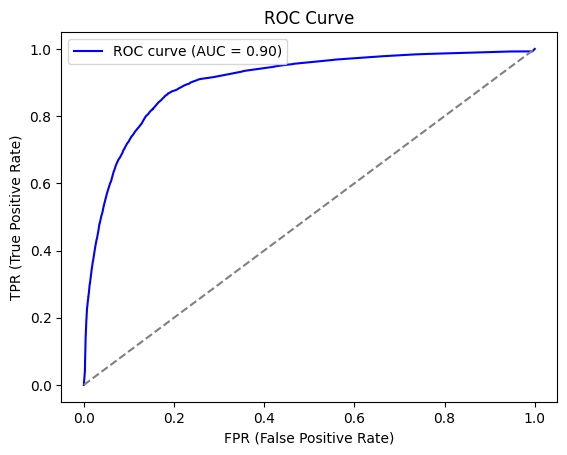

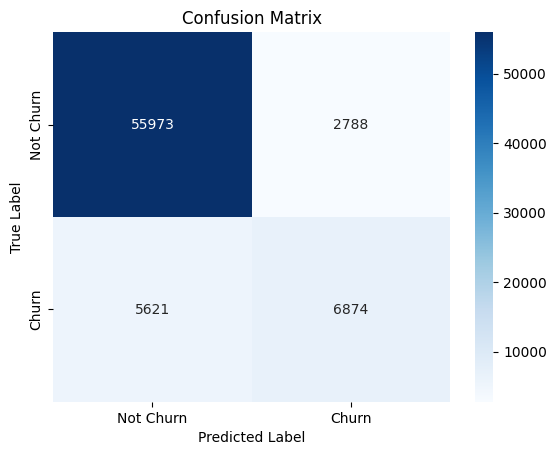

In [38]:
# ROC Curve
fpr, tpr, thresholds = dt_curve[0]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
cm = dt_matrix[0]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### 의사결정나무 오버샘플링

In [ ]:
# skf = StratifiedKFold(n_splits=5)
# dt_clf = DecisionTreeClassifier(random_state=42)
# params = {
#     # "max_depth": [50,55,60,65,70,75,80,85,90,95,100]
#     "max_depth": [51,52,53,54,55,56,57,58,59]
#     # "max_depth": [5,10,15,20,25,30,35,40,45,50]
#     # "max_depth": [1,2,3,4,5,6,7,8,9,10,11,12]
# }
# gscv_tree = GridSearchCV (dt_clf, params, scoring ='accuracy', cv = skf)
# gscv_tree.fit(X_train_scaled, y_train)
# print(gscv_tree.best_estimator_)

In [22]:
stratified_kfold = StratifiedKFold(n_splits=5)
dt_clf_over = DecisionTreeClassifier(max_depth=53, random_state=42)

dt_accuracy_over = []
dt_precision_over = []
dt_recall_over = []
dt_matrix_over = []
dt_curve_over = []

for train_index, val_index in stratified_kfold.split(X_res, y_res):
    X_train_1, y_train_1 = X_res.iloc[train_index], y_res.iloc[train_index]
    X_val, y_val = X_res.iloc[val_index], y_res.iloc[val_index]

    scaler = StandardScaler()
    X_train_scaled_1 = scaler.fit_transform(X_train_1)
    X_test_scaled_1 = scaler.transform(X_val)

    dt_clf_over.fit(X_train_scaled_1, y_train_1)
    y_pred_dt = dt_clf_over.predict(X_test_scaled_1)   # 검증 데이터로 예측
    y_pred_proba = dt_clf_over.predict_proba(X_test_scaled_1)[:, 1]

    dt_accuracy_over.append(accuracy_score(y_val, y_pred_dt))
    dt_precision_over.append(precision_score(y_val, y_pred_dt))
    dt_recall_over.append(recall_score(y_val, y_pred_dt))
    dt_matrix_over.append(confusion_matrix(y_val, y_pred_dt))
    dt_curve_over.append(roc_curve(y_val, y_pred_proba))

print("의사결정나무 정확도:", round(np.mean(dt_accuracy_over),3))
print("의사결정나무 정밀도:", round(np.mean(dt_precision_over),3))
print("의사결정나무 재현율:", round(np.mean(dt_recall_over),3))

의사결정나무 정확도: 0.942
의사결정나무 정밀도: 0.899
의사결정나무 재현율: 0.997


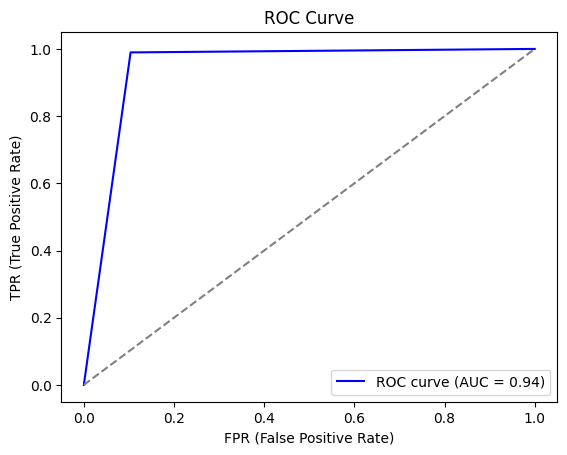

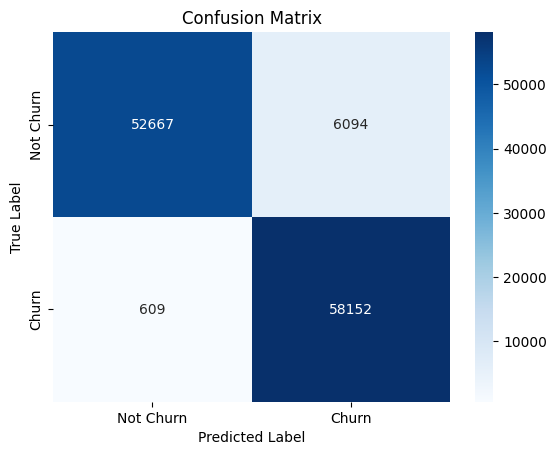

In [44]:
# ROC Curve
fpr, tpr, thresholds = dt_curve_over[0]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
cm = dt_matrix_over[0]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### 랜덤 포레스트

In [ ]:
# stratified_kfold = StratifiedKFold(n_splits=5)
# param_grid = {
#     # 'n_estimators': [50, 100, 150],       # 트리의 개수
#     # 'max_depth': [5, 10, 20, 30, 40, 50]       # 트리의 최대 깊이
#     'n_estimators': [150],       # 트리의 개수
#     # 'max_depth': [45,50,55,60,65,70]       # 트리의 최대 깊이
#     'max_depth': [46,47,48,49,50,51,52,53,54]       # 트리의 최대 깊이
# }

# # RandomForestClassifier 모델 생성
# rf_model = RandomForestClassifier(random_state=42, warm_start=True)

# # GridSearchCV를 이용한 하이퍼파라미터 튜닝
# grid_search = GridSearchCV(rf_model, param_grid=param_grid, scoring="accuracy", cv=stratified_kfold, verbose=2, n_jobs=4)

# # 모델 학습
# grid_search.fit(X_train_scaled, y_train)

# # 최적 하이퍼파라미터 출력
# print("Best Parameters:", grid_search.best_params_)

In [25]:
stratified_kfold = StratifiedKFold(n_splits=5)
rf_clf = RandomForestClassifier(max_depth= 51, n_estimators= 150, random_state=42, warm_start=True)

rf_accuracy = []
rf_precision = []
rf_recall = []
rf_matrix = []
rf_curve = []

for train_index, val_index in stratified_kfold.split(X, y):
    X_train_1, y_train_1 = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]

    rf_clf.fit(X_train_1, y_train_1)
    y_pred_rf = rf_clf.predict(X_val)
    y_pred_proba = rf_clf.predict_proba(X_val)[:, 1]

    rf_accuracy.append(accuracy_score(y_val, y_pred_rf))
    rf_precision.append(precision_score(y_val, y_pred_rf))
    rf_recall.append(recall_score(y_val, y_pred_rf))
    rf_matrix.append(confusion_matrix(y_val, y_pred_rf))
    rf_curve.append(roc_curve(y_val, y_pred_proba))

print("RF 정확도:", round(np.mean(rf_accuracy),3))
print("RF 정밀도:", round(np.mean(rf_precision),3))
print("RF 재현율:", round(np.mean(rf_recall),3))

RF 정확도: 0.978
RF 정밀도: 0.951
RF 재현율: 0.909


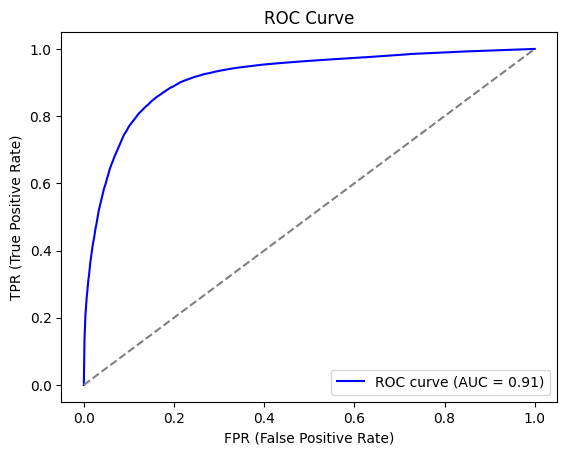

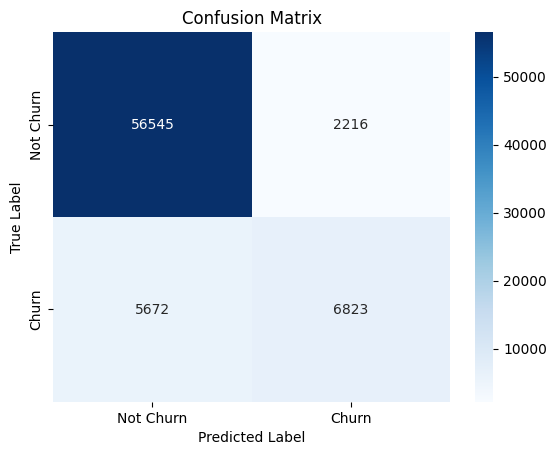

In [36]:
# ROC Curve
fpr, tpr, thresholds = rf_curve[0]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
# cm = confusion_matrix(y_val, y_pred_rf)
cm = rf_matrix[0]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### 랜덤 포레스트 오버샘플링

In [ ]:
# stratified_kfold = StratifiedKFold(n_splits=5)

# param_grid = {
#     # 'n_estimators': [50, 100, 150],       # 트리의 개수
#     # 'max_depth': [5, 10, 20, 30, 40, 50]       # 트리의 최대 깊이
#     # 'max_depth': [45,50,55,60,65,70] ,      # 트리의 최대 깊이
#     'max_depth': [61,62,63,64,65,66,67,68,69],       # 트리의 최대 깊이
#     'n_estimators': [100]       # 트리의 개수
# }

# # RandomForestClassifier 모델 생성
# rf_model = RandomForestClassifier(random_state=42, warm_start=True)

# # GridSearchCV를 이용한 하이퍼파라미터 튜닝
# grid_search = GridSearchCV(rf_model, param_grid=param_grid, scoring="accuracy", cv=stratified_kfold, verbose=2, n_jobs=4)

# # 모델 학습
# grid_search.fit(X_train_res_scaled, y_train_res)

# # 최적 하이퍼파라미터 출력
# print("Best Parameters:", grid_search.best_params_)

In [27]:
stratified_kfold = StratifiedKFold(n_splits=5)
rf_clf_over = RandomForestClassifier(max_depth= 61, n_estimators= 100, random_state=42, warm_start=True)

rf_accuracy_over = []
rf_precision_over = []
rf_recall_over = []
rf_matrix_over = []
rf_curve_over = []

for train_index, val_index in stratified_kfold.split(X_res, y_res):
    X_train_1, y_train_1 = X_res.iloc[train_index], y_res.iloc[train_index]
    X_val, y_val = X_res.iloc[val_index], y_res.iloc[val_index]

    rf_clf_over.fit(X_train_1, y_train_1)
    y_pred_rf = rf_clf_over.predict(X_val)
    y_pred_proba = rf_clf_over.predict_proba(X_val)[:, 1]

    rf_accuracy_over.append(accuracy_score(y_val, y_pred_rf))
    rf_precision_over.append(precision_score(y_val, y_pred_rf))
    rf_recall_over.append(recall_score(y_val, y_pred_rf))
    rf_matrix_over.append(confusion_matrix(y_val, y_pred_rf))
    rf_curve_over.append(roc_curve(y_val, y_pred_proba))

print("RF 정확도:", round(np.mean(rf_accuracy_over),3))
print("RF 정밀도:", round(np.mean(rf_precision_over),3))
print("RF 재현율:", round(np.mean(rf_recall_over),3))

RF 정확도: 0.992
RF 정밀도: 0.987
RF 재현율: 0.998


In [34]:
rf_accuracy_over[0],rf_precision_over[0],rf_recall_over[0]

(0.9617433331631524, 0.9353668907751801, 0.9920355337724001)

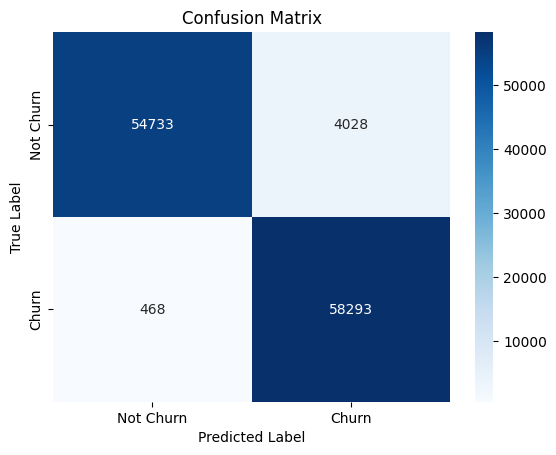

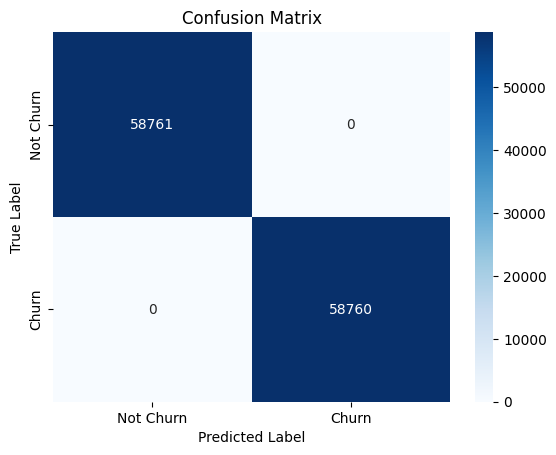

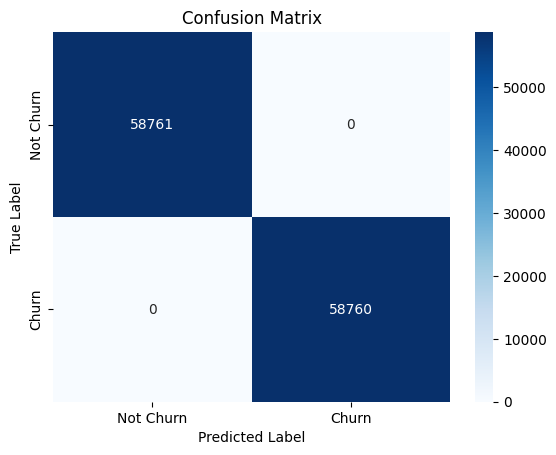

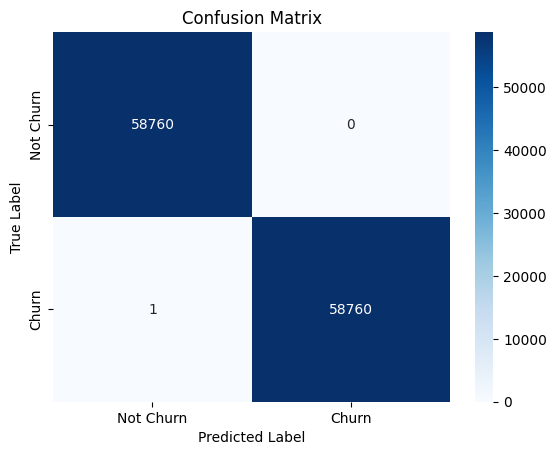

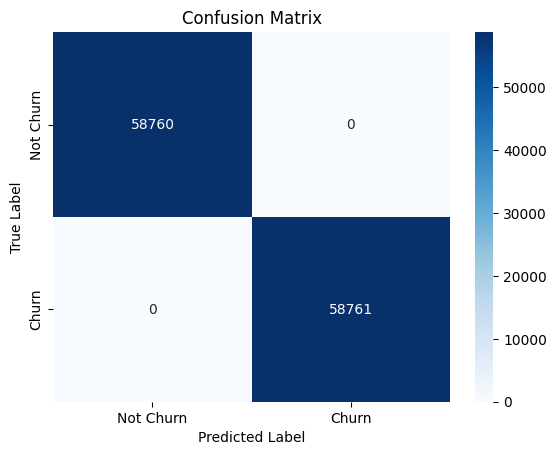

In [39]:
for i in range(len(rf_matrix_over)):
    cm = rf_matrix_over[i]

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

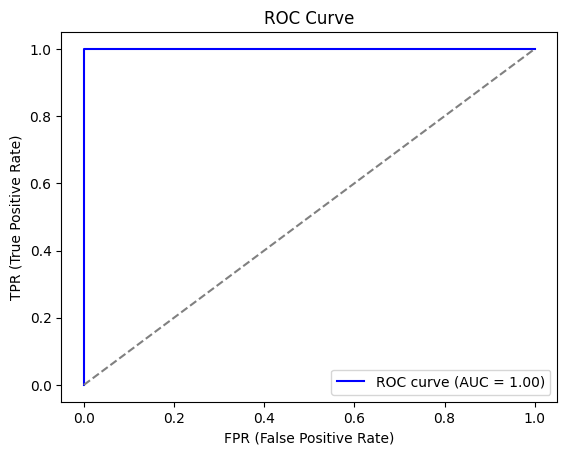

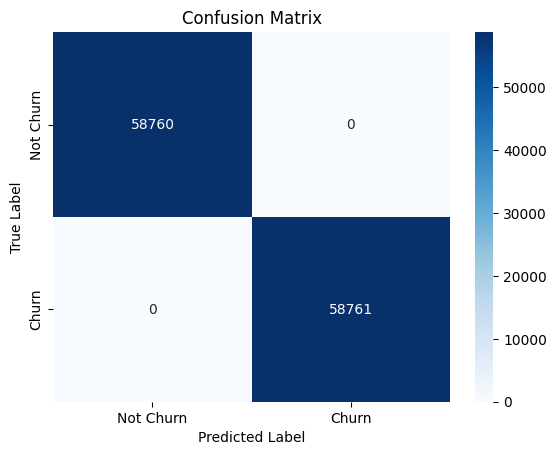

In [50]:
# ROC Curve
fpr, tpr, thresholds = rf_curve_over[4]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
# cm = confusion_matrix(y_val, y_pred_rf)
cm = rf_matrix_over[4]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


클러스터 체크

In [51]:
total_res = pd.concat([X_res, y_res], axis=1)

In [54]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300,random_state=0)
kmeans.fit(X_res)
total_res['cluster'] = kmeans.labels_
total_res['cluster_chk'] = total_res['is_churn'] - total_res['cluster']
total_res['cluster_chk'].value_counts()

cluster_chk
 1    293802
 0    293795
-1         9
Name: count, dtype: int64

### XGBoost

In [31]:
# 최적의 파라미터 찾기 - GridSearchCV
param_grid = {
    'max_depth': [7,10,15,20,25,30],
    'learning_rate': [0.2,0.3,0.4,0.5],
    'n_estimators': [300, 400,500,700],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'min_child_weight': [5,7,10,15]
}

stratified_kfold = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, tree_method="gpu_hist"),
    param_grid=param_grid,
    scoring='f1',
    cv=stratified_kfold,
    verbose=1,
    n_jobs=-1
)

# GridSearchCV 실행
grid_search.fit(X_train_scaled, y_train)

# 최적의 파라미터 출력
print(f"🏆 최적의 하이퍼파라미터: {grid_search.best_params_}")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


ValueError: 
All the 1920 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:04] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:04] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:05] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:05] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:06] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:06] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:07] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:07] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:08] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:08] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:09] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:09] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:10] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:10] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:11] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:11] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:12] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:12] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:13] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:13] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:14] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:14] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:15] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:15] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:16] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:16] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:17] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:17] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:18] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:18] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:19] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:19] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:20] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:20] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:21] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:21] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:22] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:22] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:23] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:23] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:24] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:24] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:25] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:25] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:26] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:26] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:27] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:27] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:28] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:28] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:29] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:29] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:30] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:30] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:31] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:31] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:32] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:32] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:33] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:33] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:34] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:34] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:35] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:35] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:36] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:36] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:37] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:37] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:38] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:38] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:39] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:39] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:40] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:40] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:41] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:41] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:42] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:42] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:43] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:43] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:44] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:44] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:45] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:45] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:46] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:46] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:47] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:47] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:48] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:48] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:49] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:49] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:50] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:50] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:51] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:51] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:52] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:52] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:53] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:53] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:54] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:54] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:55] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:55] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:56] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:56] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:57] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:57] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:58] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:58] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:48:59] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:48:59] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:00] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:00] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:01] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:01] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:02] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:02] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:03] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:03] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:04] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:04] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:05] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:05] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:06] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:06] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:07] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:07] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:08] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:08] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:09] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:09] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:10] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:10] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:11] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:11] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:12] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:12] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:13] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:13] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:14] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:14] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:15] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:15] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:16] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:16] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:17] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:17] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:18] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:18] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:19] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:19] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:20] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:20] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:21] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:21] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:22] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:22] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:23] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:23] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:24] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:24] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:25] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:25] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:26] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:26] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:27] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:27] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:28] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:28] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:29] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:29] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:30] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:30] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:31] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:31] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:32] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:32] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:33] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:33] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:34] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:34] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:35] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:35] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:36] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:36] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:37] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:37] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:38] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:38] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:39] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:39] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:40] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:40] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:41] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:41] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:42] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:42] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:43] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:43] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:44] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:44] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:45] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:45] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:46] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:46] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:47] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:47] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:48] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:48] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:49] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:49] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:50] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:50] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:51] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:51] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:52] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:52] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:53] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:53] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:54] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:54] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:55] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:55] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:56] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:56] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:57] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:57] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:58] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:58] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:49:59] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:49:59] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:00] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:00] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:01] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:01] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:02] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:02] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:03] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:03] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:04] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:04] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:05] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:05] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:06] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:06] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:07] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:07] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:08] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:08] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:09] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:09] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:10] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:10] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:11] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:11] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:12] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:12] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:13] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:13] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:14] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:14] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:15] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:15] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:16] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:16] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:17] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:17] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:18] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:18] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:19] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:19] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:20] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:20] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:21] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:21] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:22] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:22] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:23] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:23] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:24] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:24] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:25] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:25] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:26] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:26] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:27] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:27] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:28] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:28] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:29] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:29] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:30] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:30] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:31] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:31] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:32] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:32] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:33] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:33] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:34] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:34] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:35] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:35] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:36] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:36] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:37] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:37] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:38] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:38] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:39] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:39] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:40] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:40] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:41] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:41] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [13:50:42] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:50:42] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device



In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5)
xgb_clf = XGBClassifier(colsample_bytree= 1.0, learning_rate= 0.2, max_depth= 7, min_child_weight= 5, n_estimators= 300, subsample= 1.0, random_state=42)

xgb_accuracy=[]
xgb_precision=[]
xgb_recall=[]
xgb_matrix=[]
xgb_curve=[]

for train_index, val_index in stratified_kfold.split(X, y):
  X_train_1, y_train_1 = X.iloc[train_index], y.iloc[train_index]
  X_val, y_val = X.iloc[val_index], y.iloc[val_index]
  
  scaler = StandardScaler()
  X_train_scaled_1 = scaler.fit_transform(X_train_1)
  X_test_scaled_1 = scaler.transform(X_val)

  xgb_clf.fit(X_train_scaled_1, y_train_1)
  y_pred_xgb = xgb_clf.predict(X_test_scaled_1)
  y_pred_proba = xgb_clf.predict_proba(X_test_scaled_1)[:, 1]

  xgb_accuracy.append(accuracy_score(y_val, y_pred_xgb))
  xgb_precision.append(precision_score(y_val, y_pred_xgb))
  xgb_recall.append(recall_score(y_val, y_pred_xgb))
  xgb_matrix.append(confusion_matrix(y_val, y_pred_xgb))
  xgb_curve.append(roc_curve(y_val, y_pred_proba))

print("xgboost 정확도:", round(np.mean(xgb_accuracy),3))
print("xgboost 정밀도:", round(np.mean(xgb_precision),3))
print("xgboost 재현율:", round(np.mean(xgb_recall),3))

xgboost 정확도: 0.8878007672937368
xgboost 정밀도: 0.7254686836513455
xgboost 재현율: 0.5800171235454322


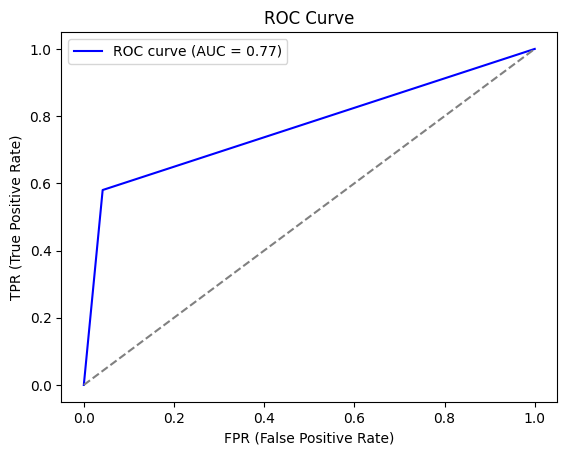

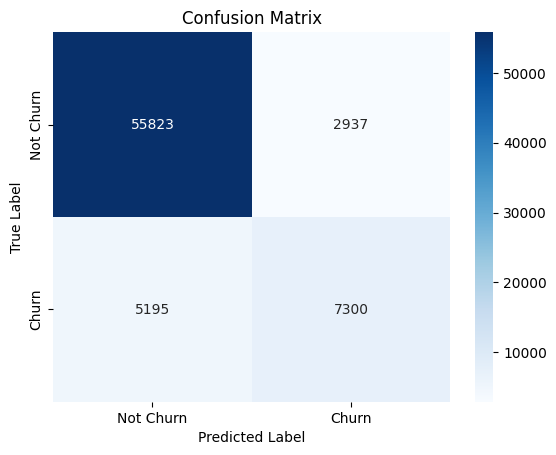

XGBoostError: No evaluation result, `eval_set` is not used during training.

In [ ]:
# ROC Curve
fpr, tpr, thresholds = xgb_curve[0]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
cm = confusion_matrix(y_val, y_pred_xgb)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### XGBoost 오버샘플링

In [ ]:
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'min_child_weight': [1, 3, 5]
# }

# stratified_kfold = StratifiedKFold(n_splits=5)

# xgb_clf = XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     random_state=42,
#     tree_method="gpu_hist"
# )

# grid_search = GridSearchCV(
#     estimator=xgb_clf,
#     param_grid=param_grid,
#     scoring='f1',
#     cv=stratified_kfold,
#     verbose=1,
#     n_jobs=-1
# )

# grid_search.fit(X_res_scaled, y_res)

# # 최적의 파라미터 출력
# print(f"🏆 최적의 하이퍼파라미터: {grid_search.best_params_}")

In [ ]:

stratified_kfold = StratifiedKFold(n_splits=5)
xgb_clf_over = XGBClassifier(colsample_bytree= 1.0, learning_rate= 0.2, max_depth= 7, min_child_weight= 1, n_estimators= 300, subsample= 0.8, random_state=42)

xgb_accuracy_over=[]
xgb_precision_over=[]
xgb_recall_over=[]
xgb_matrix_over=[]
xgb_curve_over=[]

for train_index, val_index in stratified_kfold.split(X_res, y_res):
  X_train_1, y_train_1 = X_res.iloc[train_index], y_res.iloc[train_index]
  X_val, y_val = X_res.iloc[val_index], y_res.iloc[val_index]
  
  scaler = StandardScaler()
  X_train_scaled_1 = scaler.fit_transform(X_train_1)
  X_test_scaled_1 = scaler.transform(X_val)

  xgb_clf_over.fit(X_train_scaled_1, y_train_1)
  y_pred_xgb = xgb_clf_over.predict(X_test_scaled_1)
  y_pred_proba = xgb_clf_over.predict_proba(X_test_scaled_1)[:, 1]

  xgb_accuracy_over.append(accuracy_score(y_val, y_pred_xgb))
  xgb_precision_over.append(precision_score(y_val, y_pred_xgb))
  xgb_recall_over.append(recall_score(y_val, y_pred_xgb))
  xgb_matrix_over.append(confusion_matrix(y_val, y_pred_xgb))
  xgb_curve_over.append(roc_curve(y_val, y_pred_proba))

print("xgboost 정확도:", round(np.mean(xgb_accuracy_over),3))
print("xgboost 정밀도:", round(np.mean(xgb_precision_over),3))
print("xgboost 재현율:", round(np.mean(xgb_recall_over),3))

xgboost 정확도: 0.8785359416402903
xgboost 정밀도: 0.8512518975689807
xgboost 재현율: 0.9176318855943186


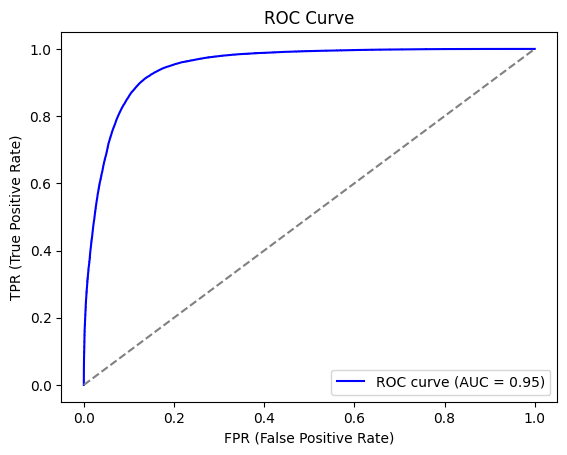

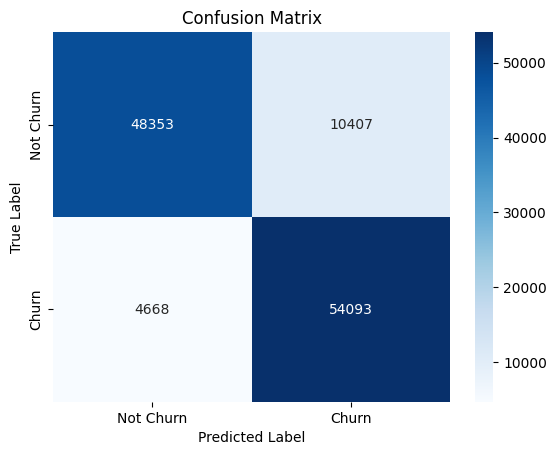

In [13]:
# ROC Curve
fpr, tpr, thresholds = xgb_curve_over[0]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
cm = confusion_matrix(y_val, y_pred_xgb)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### LightGBM

In [ ]:
# model = lgb.LGBMClassifier()

# # 하이퍼파라미터 그리드 설정
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],   # 학습률
#     'max_depth': [3, 5, 7, 10],                # 트리의 최대 깊이
#     'n_estimators': [50, 100, 150]             # 추정기 수
# }
# skf = StratifiedKFold(n_splits=5)
# # GridSearchCV를 사용하여 하이퍼파라미터 튜닝
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, n_jobs=-1, scoring='accuracy')

# # 훈련 데이터로 모델 학습
# grid_search.fit(X_train, y_train)

# # 최적의 파라미터 출력
# print("Best hyperparameters: ", grid_search.best_params_)

In [14]:
stratified_kfold = StratifiedKFold(n_splits=5)
lgbm_clf = lgb.LGBMClassifier(learning_rate= 0.2, max_depth= 7, n_estimators= 150, random_state=42)

lgbm_accuracy = []
lgbm_precision = []
lgbm_recall = []
lgbm_matrix = []
lgbm_curve = []

for train_index, val_index in stratified_kfold.split(X, y):
    X_train_1, y_train_1 = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
  
    scaler = StandardScaler()
    X_train_scaled_1 = scaler.fit_transform(X_train_1)
    X_test_scaled_1 = scaler.transform(X_val)

    lgbm_clf.fit(X_train_scaled_1, y_train_1)
    y_pred_lgbm = lgbm_clf.predict(X_val)
    y_pred_proba = lgbm_clf.predict_proba(X_val)[:, 1]

    lgbm_accuracy.append(accuracy_score(y_val, y_pred_lgbm))
    lgbm_precision.append(precision_score(y_val, y_pred_lgbm))
    lgbm_recall.append(recall_score(y_val, y_pred_lgbm))
    lgbm_matrix.append(confusion_matrix(y_val, y_pred_lgbm))
    lgbm_curve.append(roc_curve(y_val, y_pred_proba))

print("LightGBM 정확도:", round(np.mean(lgbm_accuracy),3))
print("LightGBM 정밀도:", round(np.mean(lgbm_precision),3))
print("LightGBM 재현율:", round(np.mean(lgbm_recall),3))

c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 49979, number of negative: 235042
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3708
[LightGBM] [Info] Number of data points in the train set: 285021, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175352 -> initscore=-1.548161
[LightGBM] [Info] Start training from score -1.548161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 49979, number of negative: 235042
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3698
[LightGBM] [Info] Number of data points in the train set: 285021, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175352 -> initscore=-1.548161
[LightGBM] [Info] Start training from score -1.548161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 49980, number of negative: 235042
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3693
[LightGBM] [Info] Number of data points in the train set: 285022, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175355 -> initscore=-1.548141
[LightGBM] [Info] Start training from score -1.548141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 49979, number of negative: 235043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3686
[LightGBM] [Info] Number of data points in the train set: 285022, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175351 -> initscore=-1.548166
[LightGBM] [Info] Start training from score -1.548166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 49979, number of negative: 235043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3678
[LightGBM] [Info] Number of data points in the train set: 285022, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175351 -> initscore=-1.548166
[LightGBM] [Info] Start training from score -1.548166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM 정확도: 0.801
LightGBM 정밀도: 0.36
LightGBM 재현율: 0.408


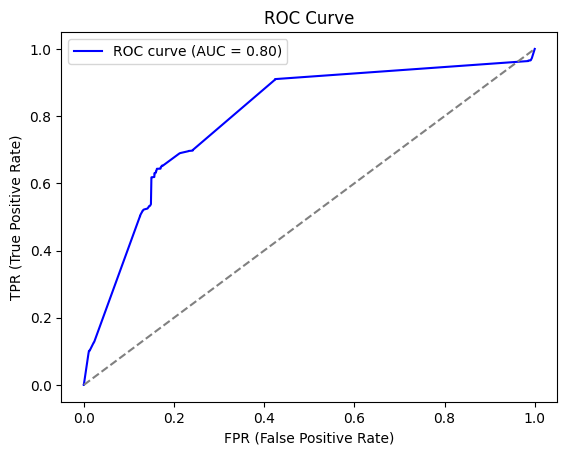

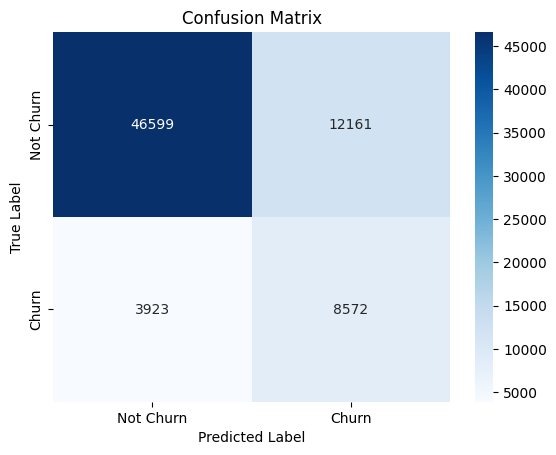

In [15]:
# ROC Curve
fpr, tpr, thresholds = lgbm_curve[0]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
cm = confusion_matrix(y_val, y_pred_lgbm)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### LightGBM 오버샘플링

In [ ]:
# # LightGBM 모델 정의
# model = lgb.LGBMClassifier()

# # 하이퍼파라미터 그리드 설정
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],   # 학습률
#     'max_depth': [3, 5, 7, 10],                # 트리의 최대 깊이
#     'n_estimators': [50, 100, 150]             # 추정기 수
# }
# skf = StratifiedKFold(n_splits=5)
# # GridSearchCV를 사용하여 하이퍼파라미터 튜닝
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, n_jobs=-1, scoring='accuracy')

# # 훈련 데이터로 모델 학습
# grid_search.fit(X_train, y_train)

# # 최적의 파라미터 출력
# print("Best hyperparameters: ", grid_search.best_params_)

In [55]:
stratified_kfold = StratifiedKFold(n_splits=5)
lgbm_clf_over = lgb.LGBMClassifier(learning_rate= 0.4, max_depth= 30, n_estimators= 1500, random_state=42)

lgbm_accuracy_over = []
lgbm_precision_over = []
lgbm_recall_over = []
lgbm_matrix_over = []
lgbm_curve_over = []

for train_index, val_index in stratified_kfold.split(X_res, y_res):
    X_train_1, y_train_1 = X_res.iloc[train_index], y_res.iloc[train_index]
    X_val, y_val = X_res.iloc[val_index], y_res.iloc[val_index]
  
    scaler = StandardScaler()
    X_train_scaled_1 = scaler.fit_transform(X_train_1)
    X_test_scaled_1 = scaler.transform(X_val)

    lgbm_clf_over.fit(X_train_scaled_1, y_train_1)
    y_pred_lgbm = lgbm_clf_over.predict(X_val)
    y_pred_proba = lgbm_clf_over.predict_proba(X_val)[:, 1]

    lgbm_accuracy_over.append(accuracy_score(y_val, y_pred_lgbm))
    lgbm_precision_over.append(precision_score(y_val, y_pred_lgbm))
    lgbm_recall_over.append(recall_score(y_val, y_pred_lgbm))
    lgbm_matrix_over.append(confusion_matrix(y_val, y_pred_lgbm))
    lgbm_curve_over.append(roc_curve(y_val, y_pred_proba))

print("LightGBM 정확도:", round(np.mean(lgbm_accuracy_over),3))
print("LightGBM 정밀도:", round(np.mean(lgbm_precision_over),3))
print("LightGBM 재현율:", round(np.mean(lgbm_recall_over),3))

[LightGBM] [Info] Number of positive: 235042, number of negative: 235042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3771
[LightGBM] [Info] Number of data points in the train set: 470084, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 235043, number of negative: 235042
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3772
[LightGBM] [Info] Number of data points in the train set: 470085, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000004
[LightGBM] [Info] Start training from score 0.000004

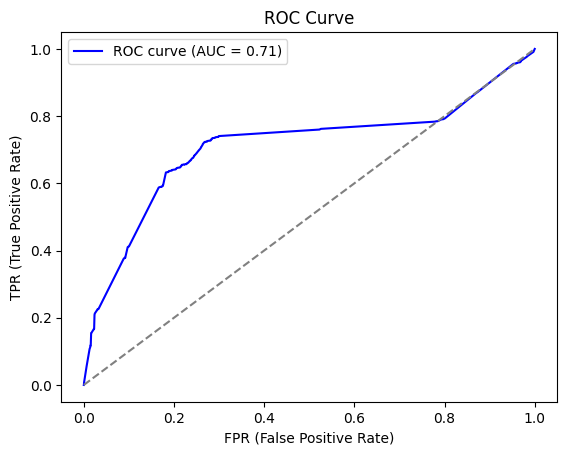

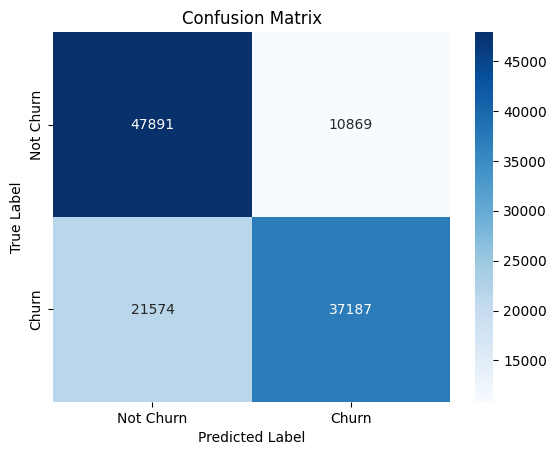

In [57]:
# ROC Curve
fpr, tpr, thresholds = lgbm_curve_over[4]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
cm = confusion_matrix(y_val, y_pred_lgbm)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()